# Research Notebook
Lukas Lehmann (Student) <br>
Date: Jan. 20. - 26.

# 1: Experience
## Describe at least one research activity you worked on this week. 

### 1: Experience
I have created a draft.py document, as well as a class BH in this document. This class contains the following functions written by me:
- The effective Potential $V_\text{eff} (r)$
- An derivative $\frac{d \varphi}{d r}(r)$ as well as the solution $\varphi (r)$ 
- A system of differential equations to get the time dependend movment of a particle. 

I have also implemented the draft file in my research file.

## Motivation:


In our research we want to investigate the predictions of different metrics for the behaviour of objects around black holes (BH). So this week I started to write a class BH(metric), which is defined by the given metric and whose functions can predict the behaviour of objects around the black hole. To check the functionality of my code, I first performed tests with the Schwarzschield metric. For which the results are known.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

As already mentioned, I first created a draft.py document, which contains the following code:

In [9]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import solve_ivp
import numpy.lib.scimath as sm
from scipy.optimize import fminbound
from scipy.integrate import quad
import sympy as sp

# Class definition for the black hole model
class BH:
    def __init__(self, f, g, h, param):
        """
        Initialize the black hole model with given functions and parameters.

        Parameters:
        - f, g, h: Functions describing the system's behavior.
        - param: Parameters used by the functions f, g, and h.
        """
        # Store parameters and function definitions
        self.param = param
        self.safe_f = f
        self.safe_g = g
        self.safe_h = h

        # Create lambda functions for f, g, h using provided parameters
        self.f = lambda r: self.safe_f(r, param)
        self.g = lambda r: self.safe_g(r, param)
        self.h = lambda r: self.safe_h(r, param)

    def get_paramters(self, param):
        """
        Return the given parameters.
        """
        return param 

    def set_paramters(self, param):
        """
        Set the parameters for the system, updating the function definitions.

        Parameters:
        - param: New set of parameters for the system.
        """
        self.param = param

        self.f = lambda r: self.safe_f(r, param)
        self.g = lambda r: self.safe_g(r, param)
        self.h = lambda r: self.safe_h(r, param)

    # Effective Potential
    def V_eff(self, r, sigma=0, L=1):
        """
        Compute the effective potential for a given radial coordinate 'r'.

        Parameters:
        - r: Radial coordinate.
        - sigma: Optional parameter, default is 0, -1 for partical.
        - L: Orbital angular momentum, default is 1.
        
        Returns:
        - V: Effective potential at the given r.
        """
        V = - self.f(r) * (sigma - (L ** 2) / self.h(r))
        return V


    # Method to find both the minimum and maximum of the effective potential
    def min_max_V_eff(self, r_span, sigma=0, L=1):
        """
        Find the minimum and maximum values of the effective potential V_eff
        within a given radial span.

        Parameters:
        - r_span: A tuple or list specifying the range [r_min, r_max] where we want to search for the extremum.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).

        Returns:
        - min: The radial position r_min where the effective potential is minimized.
        - max: The radial position r_max where the effective potential is maximized.
        """
        
        # Finding the minimum of the effective potential within the given range.
        # fminbound minimizes the function, so we pass the function as a lambda.
        min_value = fminbound(lambda r: self.V_eff(r, sigma=sigma, L=L), r_span[0], r_span[1])
        
        # Finding the maximum by minimizing the negative of the effective potential.
        # This is because fminbound only finds minima, so we negate the function to find the maximum.
        max_value = fminbound(lambda r: -self.V_eff(r, sigma=sigma, L=L), r_span[0], r_span[1])

        # Return both the minimum and maximum values
        return min_value, max_value
    
    # Method to compute the derivative of phi with respect to r
    def dphi_dr(self, r, sigma=0, L=1, E=1):
        """
        Calculate the derivative of the angle phi with respect to the radial distance r.

        Parameters:
        - r: The radial distance at which the derivative is evaluated.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).

        Returns:
        - The derivative of phi with respect to r at the specified radial distance.
        """
        
        # The derivative is calculated by dividing the angular momentum (L) by h(r),
        # and then multiplying by the square root of the ratio of f(r) * g(r) and the effective potential,
        # where the effective potential is modified by the energy (E) and the angular momentum (L).
        return (L / self.h(r)) * np.sqrt(self.f(r) * self.g(r) / (E**2 + self.V_eff(r, sigma, L)))

    # Method to compute phi(r) by integrating dphi/dr for each r in r_list
    def phi(self, r_list, r0, sigma=0, L=1, E=1):
        """
        Calculate the angle phi for a list of radial distances r_list by integrating the derivative dphi/dr.
        
        Parameters:
        - r_list: A list or array of radial distances where phi is to be evaluated.
        - r0: The reference radial position (default is 0), where phi(r0) is set to 0.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).
        
        Returns:
        - An array of phi values corresponding to each radial distance in r_list.
        """
        
        # Helper function to integrate dphi/dr for a single r
        def integrate_phi(r):
            integrand = lambda r_prime: self.dphi_dr(r_prime, sigma=sigma, L=L, E=E)
            phi_value, _ = quad(integrand, r0, r)
            return phi_value
        
        # Vectorize the integration function so it can be applied to each element in r_list
        vectorized_integrate_phi = np.vectorize(integrate_phi)
        
        # Compute phi values for each r in r_list
        phi_values = vectorized_integrate_phi(r_list)
        
        return phi_values

    # Equations of Motion (Solve Differential-Algebraic Equations)
    def solve_DAE(self, tau, tau_span, r_0, t_0=0, phi_0=0, sigma=0, L=1, E=1, R_s=2):
        """
        Solve the system of differential-algebraic equations (DAE) for motion around the black hole.

        Parameters:
        - tau: Time steps at which the solution is evaluated.
        - tau_span: Tuple containing the time span for the integration.
        - r_0: Initial radial position.
        - t_0: Initial time, default is 0.
        - phi_0: Initial angular position, default is 0.
        - sigma, L, E, R_s: Physical parameters used in the equations.
        
        Returns:
        - result_p: Solution for positive time direction.
        - result_n: Solution for negative time direction.
        - Falls_in: Boolean indicating if the solution falls inside the event horizon.
        """
        # Define the system of differential equations
        def DAE(tau, y, delta):
            t, r, phi = y
            """
            Delta is used to account for the fact that the sqrt of Rr dot can be positive or negative.
            Considering that an object can only escape from orbit if E < 0, delta also in other equations to make them fit my approch.
            """
            
            # Define the differential equations for t, r, and phi
            dtdtau    = delta * E / self.f(r)
            dphidtau  = delta * L / self.h(r)
            argument  = 1 / self.g(r) * ((E ** 2) / self.f(r) + sigma - (L ** 2) / self.h(r))

            # Check if the argument for radial motion is positive or negative
            if argument >= 0:
                drdtau = delta * np.sqrt(argument)
            else:
                drdtau = delta * np.emath.sqrt(argument)  # Uses complex numbers if argument is negative
                print("Warning: E < V_eff at r", r)

            return [dtdtau, drdtau, dphidtau]
        
        # Initial conditions: time, radial position, and angular position
        initial_conditions = [t_0, r_0, phi_0]

        # Solve the differential equations for both forward and backward time directions
        sol_p = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[1], method='RK45')
        sol_n = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[-1], method='RK45')

        Falls_in = False

        # Function to check if the solution falls inside the event horizon
        def Falls_in_BH(arr):
            # Find the index where the radial coordinate goes below the Schwarzschild radius
            index = np.argmax(arr.y[1] < R_s)

            # Check if the radial coordinate falls inside the black hole
            if sol_n.y[1][index] < R_s:
                result = arr.y[:, :index]  # Return the solution up to the event horizon
                Falls_in = True
            else:
                result = arr.y[:]  # Return the full solution

            return result

        # Get the solutions for both directions
        result_p = Falls_in_BH(sol_p)
        result_n = Falls_in_BH(sol_n)

        return result_p, result_n, Falls_in

To test the code I also implemented the following code in a jupyter notebook file, where the metric used is already an extended Schwarzschield metric, by setting $Q_b$ and $Q_c$ to 0 we get the Schwarzschield metric. 

In [10]:
# definig variables 
gamma = np.log(2) / (np.sqrt(3) * np.pi)
beta_b, beta_c = 0, 0
L_0 = 5 
M = 1 # Mass of the BH

# definitions to calculate Q_b/c in dependence of beta and L_0 which gives us more possibilitys  to compare the influence of Q_b/c on different eq.
def Q_b (beta_b, L_0):
    return abs(beta_b) * gamma ** 2 * L_0 ** 2

def Q_c (beta_c, L_0):
    return abs(beta_c) * gamma ** 2 * L_0 ** 6

# defining the functions f, g and h 
def functions(r, param = [beta_b, beta_c, L_0]):
    beta_b, beta_c, L_0 = param
    Q_b_value = Q_b(beta_b, L_0)
    Q_c_value = Q_c(beta_c, L_0)

    R_s = 2 * M

    f = (1 + Q_b_value / r**2) * (1 + Q_c_value * R_s**2 / (4 * r**8))**(-1 / 4) * ( 1 - R_s / np.sqrt(r**2 + Q_b_value))
    g = (1 + Q_c_value * R_s**2 / (4 * r**8))**(1 / 4) * (1 - R_s / np.sqrt(r**2 + Q_b_value))**(-1)
    h = r**2 * (1 + Q_c_value * R_s**2 / (4 * r**8))**(1 / 4)

    return f, g, h

f = lambda r, param: functions(r ,param)[0]
g = lambda r, param: functions(r ,param)[1]
h = lambda r, param: functions(r ,param)[2]

BH = BH(f, g, h, [beta_b, beta_c, L_0])



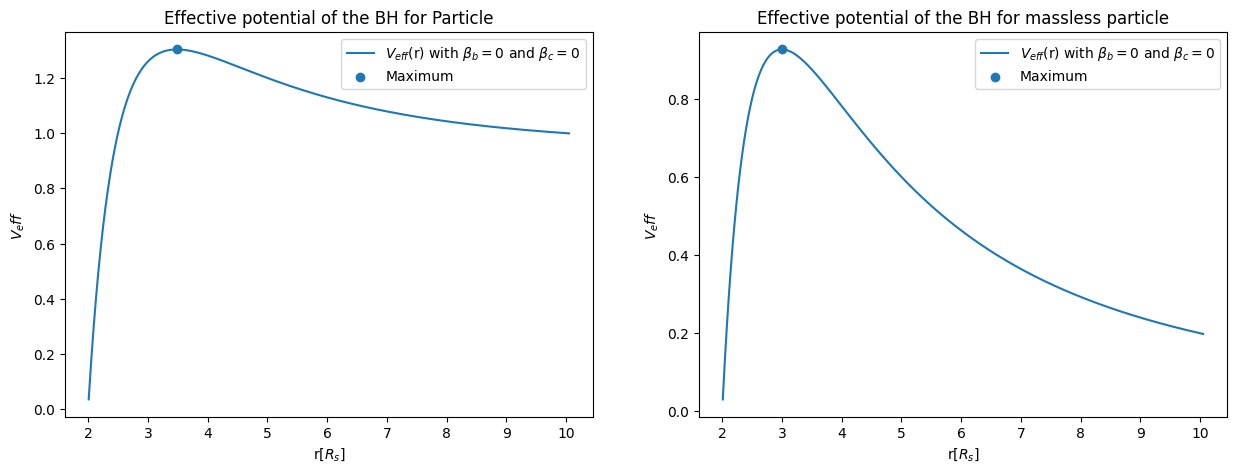

In [11]:
r_list = np.linspace(2 * M + 0.01, (2 * M + 0.01) * 5, 1000) 

min_particle, max_particle = BH.min_max_V_eff([2 * M + 0.01, (2 * M + 0.01) * 10],-1, L_0)
min, max = BH.min_max_V_eff([2 * M + 0.01, (2 * M + 0.01) * 10],0, L_0)

V_eff_list = BH.V_eff(r_list, 0, L_0)
V_eff_list_particle = BH.V_eff(r_list, -1, L_0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(r_list, V_eff_list_particle, label=fr'$V_{{eff}}$(r) with $\beta_b = 0$ and $\beta_c = 0$')  
ax1.scatter(max_particle, BH.V_eff(max_particle, -1, L_0),label='Maximum')

ax1.set_title('Effective potential of the BH for Particle') 
ax1.set_xlabel('r[$R_s$]')
ax1.set_ylabel('$V_eff$') 

ax1.legend()

ax2.plot(r_list, V_eff_list, label=fr'$V_{{eff}}$(r) with $\beta_b = 0$ and $\beta_c = 0$')  
ax2.scatter(max, BH.V_eff(max, 0, L_0),label='Maximum')

ax2.set_title('Effective potential of the BH for massless particle') 
ax2.set_xlabel('r[$R_s$]')
ax2.set_ylabel('$V_eff$') 

ax2.legend()
plt.show()

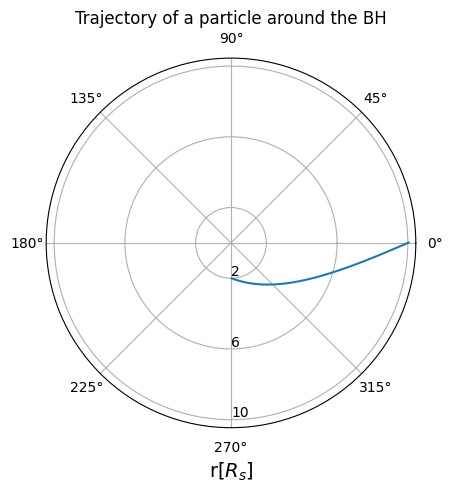

In [19]:
r_0_particle = 10

phi_list_particle = BH.phi(r_list, r_0_particle, sigma = -1, L = 15, E = -3)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot data
ax.plot(phi_list_particle, r_list)

ax.set_rticks([2, 6, 10])
ax.set_rlabel_position(-90)  

ax.set_xlabel('r[$R_s$]', fontsize=14)
ax.set_title("Trajectory of a particle around the BH")

plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_12400\866149810.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


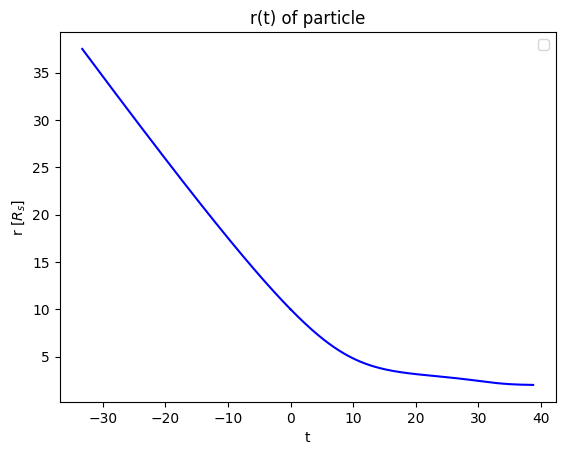

In [18]:
tau_span = [0, 10]
tau_list = np.linspace(tau_span[0], tau_span[1], 1000)

sp, sn, fall_In = BH.solve_DAE(tau_list, tau_span, sigma = -1, r_0=r_0_particle, L = 15, E = -3)

fig, ax = plt.subplots()

ax.plot(sp[0], sp[1], c= 'blue')  
ax.plot(sn[0], sn[1], c= 'blue')  

ax.set_title('r(t) of particle') 
ax.set_xlabel('t')
ax.set_ylabel('r [$R_s$]') 

ax.legend()

plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_12400\3337881602.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\lukas\AppData\Local\Temp\ipykernel_12400\3337881602.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


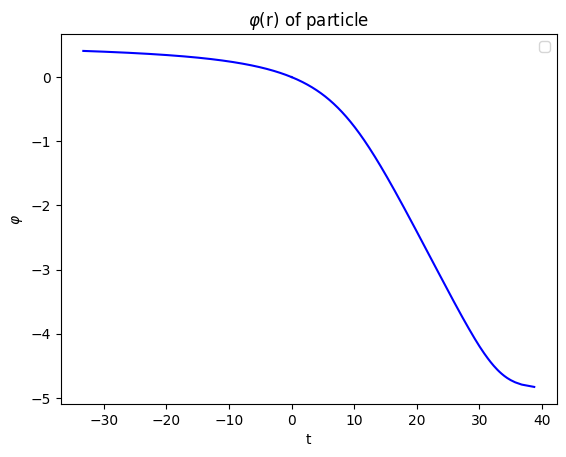

In [20]:
fig, ax = plt.subplots()

ax.plot(sp[0], sp[2], c= 'blue')  
ax.plot(sn[0], sn[2], c= 'blue')  

ax.set_title('r(t) of particle') 
ax.set_xlabel('t')
ax.set_ylabel('r [$R_s$]') 

ax.legend()
ax.set_title(rf'$\varphi$(r) of particle') 
ax.set_xlabel('t')
ax.set_ylabel(rf'$\varphi$') 

ax.legend()
plt.show()

# 3: So what? (What does it mean?)
## Describe your results

All graphs look exactly as expected. Which means the code works so far so well and now can be used for the problems with unknown output.

# 4. Now what? (What's next?)
## Plan for the next week

Next, I will extend the draft code a bit by implementing more functions, like the perihel shift. I will also try to reduce everything to analytical solutions as much as possible and include OGRePY.

# 5. Bibliography

Your references here